In [1]:
import jax 
import ticktack
import matplotlib.pyplot as pyplot
# import jupyterthemes
import functools

# jupyterthemes.jtplot.style()

In [3]:
model = ticktack.load_presaved_model("Guttler15", production_rate_units="atoms/cm^2/s")
model.compile()

MATRIX = model._matrix
PROJECTION = model._production_coefficients

del model

In [4]:
def load(filename: str, /, sep: str=","):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        _ = next(data)              # Header row for the data 

        data = jax.numpy.array(
            [row.strip().split(sep) for row in data], 
            dtype=jax.numpy.float64
        )
        
        return data.T

In [5]:
time_out = jax.numpy.linspace(0, 10, 100)

In [6]:
multiply = jax.jit(jax.vmap(jax.numpy.multiply, in_axes=(None, 0)))
matrix_multiply = jax.jit(jax.vmap(jax.numpy.matmul, in_axes=(0, None)))

In [7]:
eigenvals, eigenvecs = jax.numpy.linalg.eig(MATRIX)
eigenvecs, eigenvals = eigenvecs.real, eigenvals.real
inverse = jax.numpy.linalg.inv(eigenvecs)
initial_position = 1.0 / jax.numpy.linalg.norm(PROJECTION) * PROJECTION

In [8]:
@jax.jit
def fundamental_matrix(time_out, /, eigenvecs=eigenvecs, eigenvals=eigenvals, inverse=inverse):
    """
    This constructs the right hand side of the fundamental solution matrix. It is vectorised and so returns a three dimensional array with the third dimension spanning the time series implied by `time_out`.

    Parameters:
    -----------
    : time_out :  The time series over which the fundamental matrix is to be calculated
    : eigenvecs : The eigenvectors of the transfer matrix
    : eigenvals : The eigenvalues of the transfer matrix
    : inverse : The inverse of the eigenvectors of the transfer matrix. This could be calculated internally but since the evaluation is only required once it is passed as an argument.

    Returns:
    --------
    : DeviceArray : The fundamental solution matrix evaluated over the time series implied by `time_out`
    """
    # So I need to implement the translation of the time series back onto 0
    exponents = jax.numpy.exp(multiply(eigenvals, time_out))
    transition_matrix = multiply(eigenvecs, exponents)
    transition_matrix = matrix_multiply(transition_matrix, inverse)
    return transition_matrix

In [9]:
@jax.jit
def analytic_template(time_out, /, initial_poisition=initial_position):
    """
    Determines the analytic solution of an impulse response function over the time series provided by `time_out`.

    Parameters:
    -----------
    : time_out : The time series at which the analytic solution is to be evaluated
    : inverse : The inverse of the eigenvectors of the transfer matrix
    
    """
    transition_matrix = fundamental_matrix(time_out - time_out.min())
    return matrix_multiply(transition_matrix, initial_poisition)

In [10]:
intcal = load("/home/jordan/Documents/ticktack/src/data/datasets/IntCal20/Intcal20.csv")

In [11]:
@jax.jit
def design_matrix(time_series):
    """
    Constructs the design matrix of the linear regression. 
    
    Parameters:
    -----------
    : time_series : The time over which to evaluate the design matrix.
    
    Returns:
    --------
    : DeviceArray : A 3 by n matrix where n is the length of `time_series`.
    """
    constant = jax.numpy.ones((time_series.shape), dtype=jax.numpy.float64)
    # So I think that the prescence of the zero values is going to cause problems
    # I need to look into the `jax.lax.dynamic_slice_update()` to fix this.
    temporal = (time_series - time_series.min()) / time_series.ptp()
    analytic = analytic_template(time_series)[:, 1]
    return jax.numpy.stack([constant, temporal, analytic])

In [183]:
# These are all utility functions for the bad boy 
# The in_window function is causing headaches because it cannot be passed the data

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# This is where the error seems to be
@jax.jit
def in_window(start, data, size):
    @jax.vmap
    def comp_util(start):
        return (data[0] >= start) & (data[0] <= (start + size))
    return comp_util(start)

vec_mat = jax.jit(jax.vmap(design_matrix)) # Vectorising the deisgn matrix command
vec_reg = jax.jit(jax.vmap(jax.numpy.linalg.lstsq)) # Vectorising the lstq function 
vec_matmul = jax.jit(jax.vmap(jax.numpy.matmul))

In [184]:
@jax.jit
def vec_regression(data, /, size: int=10):
    start = data[0, :-size] # Storing as a variable for the usefulness 
    mask = in_window(start, data=data, size=size)      # Creates a boolean mask of out of date
    lead_dim = data[0].size      # A useful size parameter for the mapping 

    indices = jax.numpy.arange(start.size) # Inex entry points to get a fill value
    fill_values = jax.numpy.take(data, indices, axis=1) # Data sliced along dimension
    fill_values = fill_values.repeat(lead_dim) # Element wise repetition
    fill_values = fill_values.reshape(3, -1, lead_dim)

    data = data.tile(start.size) # Replicating the data 
    data = data.reshape(3, -1, lead_dim) # Shaping for a push through where

    # The error is here. Where is not pulling the correct data out
    masked_data = jax.numpy.where(mask, data, fill_values)
    masked_matrix = vec_mat(masked_data[0]) # Building the design matrixes

    input_arr = jax.numpy.transpose(masked_matrix, axes=(0, 2, 1)) # Gettinf the sahpe compatible with the leading dimesnion of the data
    lst_square = vec_reg(input_arr, masked_data[1])[0] # Performing regression 
    
    models = vec_matmul(lst_square, masked_matrix) # Running the models
    chi_squared = jax.numpy.sum((masked_data[1] - models) ** 2 / masked_data[2] ** 2, axis=1)
    return jax.numpy.hstack([start.reshape(-1, 1), lst_square, chi_squared.reshape(-1, 1)])

In [185]:
batched_dim = intcal.shape[1] # Chosing the largest dimension to batch along
num_batches = 8 # Number of batches (must be multiple)
leading_dim = batched_dim // num_batches # Length of the new leading dim
batched_data = intcal.reshape(3, leading_dim, num_batches) # Conforming array to batches
batched_data = jax.numpy.transpose(batched_data, axes=(2, 0, 1)) # Placing the map axis in front

In [186]:
# Here is where we run the injection recovery
coefficients = jax.numpy.vstack([vec_regression(data) for data in batched_data])

In [214]:
# So this will be the mask/index getter function. 
# I need to work out how to jit this bastard
def mask(condition, data):
    """
    The data needs to be passed such that the leading dimension is along 
    the zero axis. This function returns the data where the condition is 
    true.
    
    parameters:
    -----------
    : condition : A boolean array true where the data is to be returned 
    : data : A data array passed so that the leading dimension is on axis 0
    
    returns:
    : Array : The data where condition was true and nothing otherwise
    """
    # Note I will need to work out how to pass the leading dimesnion 
    indices = jax.numpy.arange(data[0].size) # Row indexes of nans
    indices = (indices * condition).nonzero()[0] # only nan indexes
    return jax.numpy.take(data.T, indices, axis=0) # cleaned data 

In [188]:
@jax.jit
def regression(data, /, size: int=10): 
    """
    A simple linear regression for a data subset that is unvectorised. The main
    use for this is testing the nan regipons until the vectorised is fixed
    """
    # I'm assuming the first data point is the desired start
    mask = (data[0][0] < data[0]) & (data[0] < (data[0][0] + size))  # Creates a boolean mask of out of date
    fill = data[:, 0] # Data sliced along dimension
    fill = jax.numpy.tile(fill.reshape(-1, 1), data[0].size)

    # The error is here. Where is not pulling the correct data out
    period = jax.numpy.where(mask, data, fill)
    design = design_matrix(period[0]) # Building the design matrixes
    square = jax.numpy.linalg.lstsq(design.T, period[1])[0] # Least sqaures fit
    fitted = jax.numpy.matmul(square, design) # Constructing the model
    chi_sq = jax.numpy.sum((period[1] - fitted) ** 2 / period[2] ** 2) # Chi of the fit   
    return jax.numpy.array([data[0][0], *square, chi_sq])

So I just worked out a bug. The times are currently not actively returned at any point within the injection recovery causing problems. Additionally there are blind patches in the data. 

In [189]:
nan_mask = 1 - jax.numpy.isnan(coefficients[:, 3]) # Boolean nan mask
non_nan_coef = mask(nan_mask, coefficients.T) # Masking with leading dimension switched

analytic_mean = jax.numpy.mean(non_nan_coef[:, 3]) # Mean of analytic solution coefficients
analytic_std = jax.numpy.std(non_nan_coef[:, 3]) # Standard deviation of analytic solution coefficients

threshold_mask = non_nan_coef[:, 3] > (analytic_mean + 4 * analytic_std) # A mask for cutoff at 2sd
threshold_vals = mask(threshold_mask, non_nan_coef.T) # Masked data

The code below isolates a section that resulted in nans and tries to determine the cause. Note that the un-vectorised function regression is much tidier but it will be too slow to use on the large dataset

In [215]:
pro_nan_mask = jax.numpy.isnan(coefficients[:, 3]) # Boolean nan mask
pro_nan_coef = mask(pro_nan_mask, coefficients.T)

time = pro_nan_coef[0]
time_mask = ((time[0] - 25) < intcal[0]) & (intcal[0] < (time[0] + 25))
data = mask(time_mask, intcal).T
size = 10
# model = test_time[1:-1] @ design

In [199]:
kronos = jax.numpy.linspace(time[0], time[0] + 10, 100)
params = regression(data)
design = design_matrix(kronos)
fitted = params[1:-1] @ design

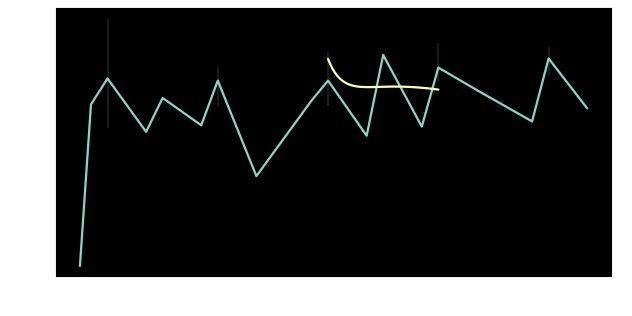

In [203]:
pyplot.figure(figsize=(10, 5))
seaborn.lineplot(x=data[0], y=data[1])
pyplot.plot(kronos, fitted)

Below I am testing the vectorized solution on the data that is presented

In [205]:
@jax.jit
def in_window(start, data, size):
    @jax.vmap
    def comp_util(start):
        return (data[0] >= start) & (data[0] <= (start + size))
    return comp_util(start)

In [206]:
# The first bug is here. Since the data is not sorted we cannot use this 
# What I might be able to do is apply the in_window function and then discard 
# values if the sum is too small
start = data[0, :-size] # Storing as a variable for the usefulness 
mask = in_window(start, data=data, size=size)      # Creates a boolean mask of out of date
lead_dim = data[0].size      # A useful size parameter for the mapping 

In [207]:
# I think again that the out-of order data is making this not work. 
# At this point it might be easier to reorder the data, in which case 
# we will get a significant speed 
# Actually this will work
indices = jax.numpy.arange(start.size) # Inex entry points to get a fill value
fill_values = jax.numpy.take(data, indices, axis=1) # Data sliced along dimension
fill_values = fill_values.repeat(lead_dim) # Element wise repetition
fill_values = fill_values.reshape(3, -1, lead_dim)

In [198]:
# indices = jax.numpy.arange(start.size) # Inex entry points to get a fill value
# fill_values = jax.numpy.take(data, indices, axis=1) # Data sliced along dimension
# test = fill_values.tile((1, lead_dim))
# test = test.reshape(3, -1, lead_dim)

In [208]:
data = data.tile(start.size) # Replicating the data 
data = data.reshape(3, -1, lead_dim) # Shaping for a push through where

In [200]:
# So what do I have here? What should the correspondence between this and the 
# fill_value array be.What I have is that this one varies across time while the 
# otherone is fixed. Is that the behaviour that I want?
# Yes I think that that is the behaviour that I want. 

In [209]:
# The error is here. Where is not pulling the correct data out
# So yeah I need to make sure that there is a minimum number of 
# data points in the set. This might imply that a better option 
# is to used a fixed window in terms of the data size
masked_data = jax.numpy.where(mask, data, fill_values)
masked_matrix = vec_mat(masked_data[0]) # Building the design matrixes

In [210]:
input_arr = jax.numpy.transpose(masked_matrix, axes=(0, 2, 1)) # Gettinf the sahpe compatible with the leading dimesnion of the data
lst_square = vec_reg(input_arr, masked_data[1])[0] # Performing regression 

In [211]:
lst_square

DeviceArray([[-6.18822201e+01, -2.49774713e+01,  9.65141987e+01],
             [-6.78445036e+01, -2.41350692e+01,  1.05235412e+02],
             [-1.39304622e+01, -5.46356280e+00, -2.02876806e+01],
             [-2.22160924e+01, -7.84893715e-01,  1.06285041e+00],
             [-2.18582378e+01, -6.80256851e+00,  8.47854392e+00],
             [-1.56480143e+01, -4.97921910e+00, -3.17271442e+00],
             [-6.95480131e+01, -2.38943829e+01,  1.07727187e+02],
             [-7.12515227e+01, -2.36536966e+01,  1.10218962e+02],
             [-9.72870339e+00, -7.45871382e+00, -2.63128057e+01],
             [-1.96028366e+01, -2.77010893e+00, -1.21537617e+01],
             [-3.02149922e+01,  3.02104545e+00,  1.25500765e+01],
             [-2.89520081e+01,  2.42010768e+00,  1.07363039e+01],
             [-4.45794716e+01,  4.03178508e+00,  4.10292594e+01],
             [-3.04838913e+01, -2.68952687e+00,  2.08357600e+01],
             [-1.96731698e+01, -8.98856263e+00,  2.22833547e+00],
          

In [175]:
# So this seems to be what we want. I just though that maybe I could use 
# The disble jit from within the jitted function to pull out the uniques
# before continuing along if it was faster.
jax.numpy.unique(input_arr[10], axis=0)

DeviceArray([[1.        , 0.        , 0.3939193 ],
             [1.        , 0.35      , 0.58706068],
             [1.        , 0.5       , 0.52667859],
             [1.        , 0.85      , 0.40608377],
             [1.        , 1.        , 0.37046941]], dtype=float64)

In [216]:
vec_regression(data)

DeviceArray([[ 5.24500000e+02, -6.18822201e+01, -2.49774713e+01,
               9.65141987e+01,  6.60103065e+00],
             [ 5.24500000e+02, -6.78445036e+01, -2.41350692e+01,
               1.05235412e+02,  1.70730939e+00],
             [ 5.14500000e+02, -1.39304622e+01, -5.46356280e+00,
              -2.02876806e+01,  1.12782657e+01],
             [ 5.04500000e+02, -2.22160924e+01, -7.84893715e-01,
               1.06285041e+00,  2.10836875e+01],
             [ 4.94500000e+02, -2.18582378e+01, -6.80256851e+00,
               8.47854392e+00,  3.87987333e+01],
             [ 4.84500000e+02, -1.56480143e+01, -4.97921910e+00,
              -3.17271442e+00,  1.60041213e+01],
             [ 5.24500000e+02, -6.95480131e+01, -2.38943829e+01,
               1.07727187e+02,  2.12351136e+00],
             [ 5.24500000e+02, -7.12515227e+01, -2.36536966e+01,
               1.10218962e+02,  3.36427468e+00],
             [ 5.14500000e+02, -9.72870339e+00, -7.45871382e+00,
              -2.631280

In [ ]:
models = vec_matmul(lst_square, masked_matrix) # Running the models
chi_squared = jax.numpy.sum((masked_data[1] - models) ** 2 / masked_data[2] ** 2, axis=1)
return jax.numpy.hstack([start.reshape(-1, 1), lst_square, chi_squared.reshape(-1, 1)])

So it might be useful to have an non-vectorized regression function for the result visualisation anyway. I will work on constructing this now 

In [35]:
%matplotlib inline

In [17]:
import seaborn
seaborn.set(style="ticks", context="talk")
pyplot.style.use("dark_background")

In [84]:
threshold = threshold_vals[:, 3].min()

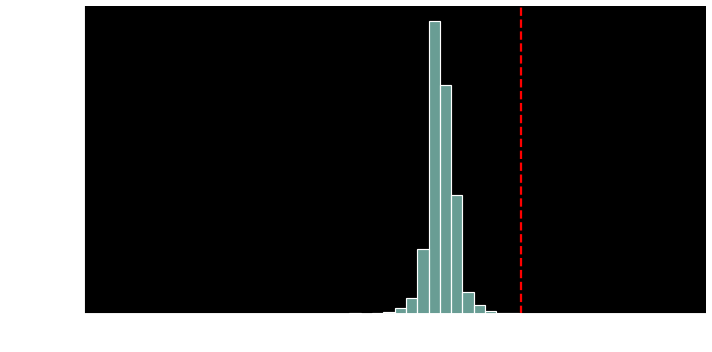

In [87]:
histogram = seaborn.displot(non_nan_coef[:, 3], bins=50, height=5, aspect=2)
histogram.refline(x=threshold, color="red")

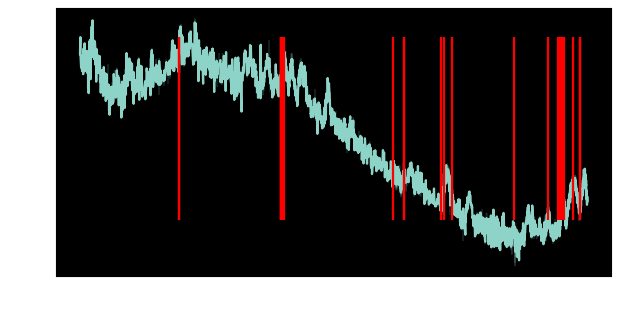

In [88]:
pyplot.figure(figsize=(10, 5))
carbon = seaborn.lineplot(x=intcal[0], y=intcal[1])
pyplot.vlines(threshold_vals[:, 0], ymin=-25, ymax=100, color="red")

The next job is to zoom in on the period of 50  years surrounding each event 

In [284]:
test_time = threshold_vals[15] # Getting a test datapoint to check with 
time_mask = ((test_time[0] - 25) < intcal[0]) & (intcal[0] < (test_time[0] + 25))
segment = mask(time_mask, intcal)

time_vals = jax.numpy.linspace(test_time[0], test_time[0] + 10, 100)
design = design_matrix(time_vals)
model = test_time[1:-1] @ design

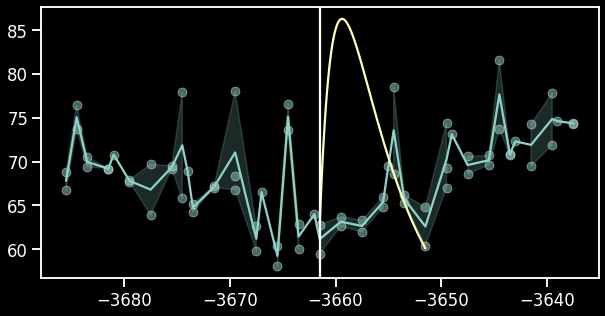

In [286]:
figure, axes = pyplot.subplots(figsize=(10, 5))
seaborn.lineplot(x=segment[:, 0], y=segment[:, 1], ax=axes)
seaborn.scatterplot(x=segment[:, 0], y=segment[:, 1], ax=axes, alpha=0.5)
seaborn.lineplot(x=time_vals, y=model, ax=axes)
pyplot.axvline(x=test_time[0])

So I have identified that the plroblem is that the size window is using 10 data points and so is two a resolution. This should be easy to fix

Nevermind the problem is in the vec_reg function. I need to debug this as a priority. I will return to using the miyake data and carefully examine it's performance

In [18]:
miyake = load("miyake12.csv", sep=" ")
coeffs = vec_regression(miyake)

Text(0.5, 1.0, 'injection recovery of miyake sample')

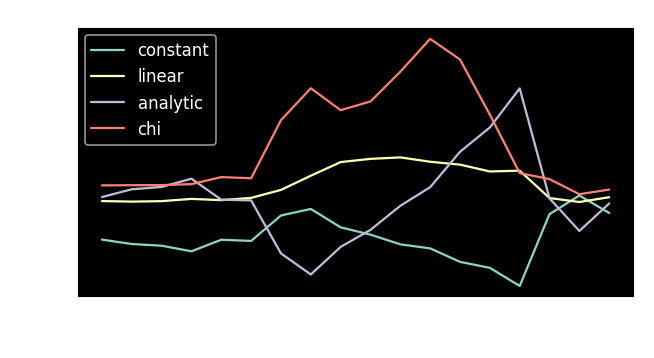

In [36]:
fig = pyplot.figure(figsize=(10, 5))
pyplot.plot(coeffs[:, 0], coeffs[:, 1:])
pyplot.legend(["constant", "linear", "analytic", "chi"])
pyplot.xlabel("time")
pyplot.ylabel("amplitude")
pyplot.title("injection recovery of miyake sample")

In [45]:
# @jax.vmap
def plot_model(coeffs, alpha):
    time = jax.numpy.linspace(coeffs[0], coeffs[0] + 10, 100)
    design = design_matrix(time)
    model = coeffs[1:-1] @ design
    pyplot.plot(time, model, color="red", alpha=alpha)

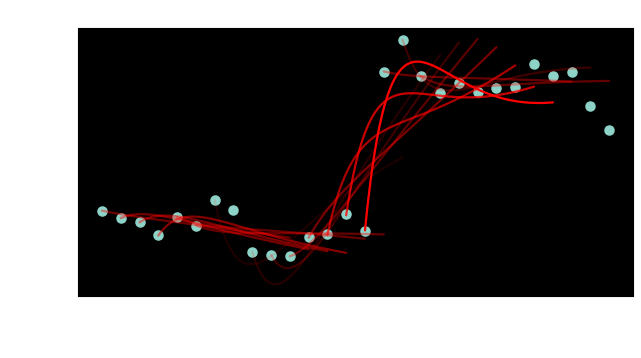

In [69]:
pyplot.figure(figsize=(10, 5))
pyplot.scatter(miyake[0], miyake[1])
pyplot.xlabel("time")
pyplot.ylabel("dc14")
pyplot.title("injection recovery on miyake data")

alphas = (coeffs[:, 3].max() - coeffs[:, 3]) / coeffs[:, 3].ptp()
alphas = 1 - alphas
alphas = map(float, alphas)

for coeff, alpha in zip(coeffs, alphas):
    plot_model(coeff, alpha)

So below this point I will be working on the data that is producing the nans. Let's see what we find.